In [2]:
import os
import random
import sys
import time

import numpy as np
import pandas as pd
import spotpy

os.chdir(sys.path[0])
sys.path.append("..")

from evaluation_metrics import nse_loss
from hydrological_models import HBV as hydrological_model
from modelcalibration import calibrate_basins
from modelcalibration_caravan import ModelCalibrationCaravan as model_calibration
from modelcalibration_caravan import check_basins_caravan as check_basins
from optimization_methods import dream as optimization_method
from spotpy.likelihoods import gaussianLikelihoodMeasErrorOut as obj_func

In [3]:
# Initialize information
path_entities = r'U:\02_Software\Github\Hy2DL_Caravan\data\basin_id\testde_3.txt'
path_data = r'U:\02_Software\Github\Hy2DL_Caravan\data\caravan'
input_variables = ['eobs','evap_eobs_column', 'temperature_2m_mean']
target_variables = ["streamflow"]
training_period = ["2000-01-01", "2010-12-31"]
testing_period = ["2011-01-01", "2016-12-31"]
batch_size = 15
warmup_period = 90
random_seed = 700

# Save results
path_output = "../results/conceptual_models_CARAVAN_schwarzbach_eobs/"

# use when one select the best parameters, depends on the loss function one wants.
maximize = True  # True for gaussian_likelihood, False of rmse

# set random seed
random.seed(random_seed)
np.random.seed(random_seed)

# Read information
basins_id = np.loadtxt(path_entities, dtype="str").tolist()
selected_basins_id = check_basins(
    path_data=path_data,
    basins_id=basins_id,
    target_variables=target_variables,
    training_period=training_period,
    testing_period=testing_period,
)

# Check if the path where one will store the results exists. In case it does not, it creates such path.
if not os.path.exists(path_output):
    # Create the folder
    os.makedirs(path_output)
    print(f"Folder '{path_output}' created successfully.")
else:
    print(f"Folder '{path_output}' already exists.")

Folder '../results/conceptual_models_CARAVAN_schwarzbach_eobs/' already exists.


In [4]:
# Process the basins in batches (avoid memory issues)
batches = [selected_basins_id[i : i + batch_size] for i in range(0, len(selected_basins_id), batch_size)]
batches

[['testde_3',
  'testde_3',
  'testde_3',
  'testde_3',
  'testde_3',
  'testde_3',
  'testde_3',
  'testde_3']]

In [5]:
# Manual changes to ensure I only have one batch for my single basin
# Caution - this is a workaround I do for running for single basins - AMJ 09.10.2024
batches = [batches[0][:1]]
batches

[['testde_3']]

In [6]:
dfs = []
start_time = time.time()
for basin_batch in batches:
    training_object = {}
    testing_object = {}

    for basin in basin_batch:
        training_object[basin] = model_calibration(
            model=hydrological_model(),
            path_data=path_data,
            basin_id=basin,
            input_variables=input_variables,
            target_variables=target_variables,
            time_period=training_period,
            obj_func=obj_func,
            warmup_period=warmup_period,
        )

        testing_object[basin] = model_calibration(
            model=hydrological_model(),
            path_data=path_data,
            basin_id=basin,
            input_variables=input_variables,
            target_variables=target_variables,
            time_period=testing_period,
            obj_func=obj_func,
            warmup_period=warmup_period,
        )

    # Run the calibration of the different basins in parallel --------------------------------------------------
    optimizer = optimization_method(random_state=random_seed)
    calibrate_basins(
        training_object=training_object,
        optimization_method=optimizer,
        basins=basin_batch,
        path_output=path_output,
        random_seed=random_seed,
    )

    # Process and summarize the results -------------------------------------------------------------------------
    hyd_model = hydrological_model()
    optimizer = optimization_method()
    df_calibration = pd.DataFrame(
        index=range(len(basin_batch)),
        columns=["basin_id", "NSE_training"] + list(hyd_model.parameter_ranges) + ["NSE_testing"],
    )

    for i, basin in enumerate(basin_batch):
        # extract calibrated parameters
        file_name = path_output + hyd_model.name + "_" + optimizer.name + "_" + str(basin)
        results = spotpy.analyser.load_csv_results(file_name)
        calibrated_param = spotpy.analyser.get_best_parameterset(results, maximize=maximize)[0]

        # Training period ------------------------------------------
        q_sim = training_object[basin].simulation(calibrated_param)
        q_obs = training_object[basin].evaluation()

        # Convert to DataFrame and save - Single Basin
        df_train = pd.DataFrame({
            'q_sim': q_sim,
            'q_obs': q_obs
        })

        df_train.to_csv(f'{path_output}{hyd_model.name}_{optimizer.name}_train_{basin}.csv', index=False)

        # Calculate loss
        evaluation = q_obs[warmup_period:][training_object[basin].data_split[warmup_period:]]
        simulation = q_sim[warmup_period:][training_object[basin].data_split[warmup_period:]]
        mask_nans = ~np.isnan(evaluation)
        NSE_training = nse_loss(
            evaluation=evaluation[mask_nans].flatten(), simulation=simulation[mask_nans].flatten()
        )

        # Testing period ------------------------------------------
        q_sim = testing_object[basin].simulation(calibrated_param)
        q_obs = testing_object[basin].evaluation()

        # Convert to DataFrame and save - Single Basin
        df_test = pd.DataFrame({
            'q_sim': q_sim,
            'q_obs': q_obs
        })

        df_test.to_csv(f'{path_output}{hyd_model.name}_{optimizer.name}_test_{basin}.csv', index=False)
        
        # Calculate loss
        evaluation = q_obs[warmup_period:][testing_object[basin].data_split[warmup_period:]]
        simulation = q_sim[warmup_period:][testing_object[basin].data_split[warmup_period:]]
        mask_nans = ~np.isnan(evaluation)
        NSE_testing = nse_loss(
            evaluation=evaluation[mask_nans].flatten(), simulation=simulation[mask_nans].flatten()
        )

        # Save the result of the basin
        df_calibration.loc[i] = [basin, NSE_training] + list(calibrated_param) + [NSE_testing]

    # Dataframe of the batch
    dfs.append(df_calibration)

 # Save the results
combined_df = pd.concat(dfs)
combined_df.to_csv(path_output + hyd_model.name + "_" + optimizer.name + "_summary.csv", index=False)
# Calculate and print the calibration time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total calibration time: {int(elapsed_time)} seconds")

Best parameter set:
BETA=1.0652149, FC=538.6393, K0=0.6935684, K1=0.39117882, K2=0.048552703, LP=0.20900364, PERC=4.55549, UZL=61.09749, TT=0.6875733, CFMAX=8.791999, CFR=0.095657416, CWH=0.079959236, alpha=2.59193, beta=0.53840727
Total calibration time: 202 seconds


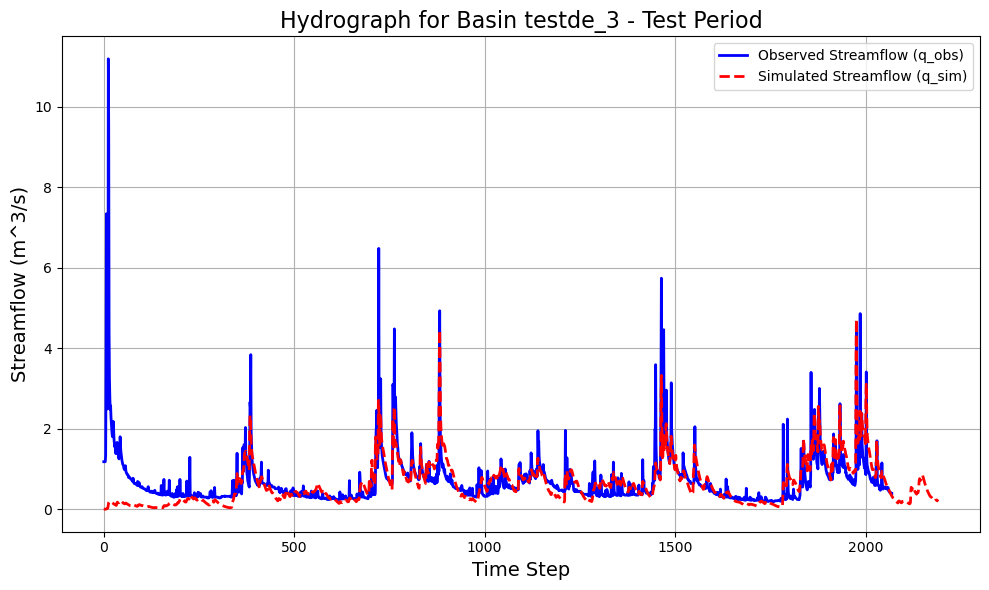

In [7]:
import matplotlib.pyplot as plt

# Read the df_test CSV file
df_test = pd.read_csv(f'{path_output}{hyd_model.name}_{optimizer.name}_test_{basin}.csv')

# Assuming the file has 'q_sim' and 'q_obs' columns
q_sim = df_test['q_sim']
q_obs = df_test['q_obs']

# Create a plot for the hydrograph
plt.figure(figsize=(10, 6))

# Plot observed streamflow
plt.plot(q_obs, label='Observed Streamflow (q_obs)', color='blue', linewidth=2)

# Plot simulated streamflow
plt.plot(q_sim, label='Simulated Streamflow (q_sim)', color='red', linestyle='--', linewidth=2)

# Adding labels and title
plt.title(f"Hydrograph for Basin {basin} - Test Period", fontsize=16)
plt.xlabel("Time Step", fontsize=14)  # Assuming each row is a time step
plt.ylabel("Streamflow (m^3/s)", fontsize=14)
plt.grid(True)

# Show the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

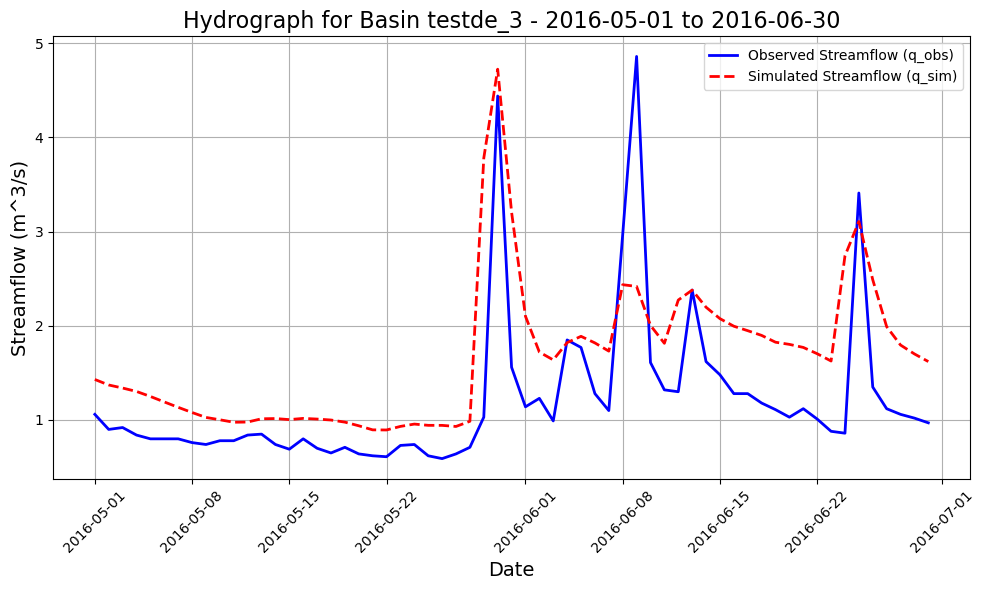

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the testing period
start_date = "2011-01-01"
end_date = "2016-12-31"

# Read the df_test CSV file
df_test = pd.read_csv(f'{path_output}{hyd_model.name}_{optimizer.name}_test_{basin}.csv')

# Assuming the file has 'q_sim' and 'q_obs' columns
q_sim = df_test['q_sim']
q_obs = df_test['q_obs']

# Create a date range based on the testing period (adjust the frequency if needed)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Ensure the date range matches the length of your data
if len(date_range) != len(q_sim):
    raise ValueError(f"The date range length {len(date_range)} does not match the data length {len(q_sim)}")

# Define the custom time window
custom_start_date = "2016-05-01"
custom_end_date = "2016-06-30"

# Filter the date range and data based on the custom time window
mask = (date_range >= custom_start_date) & (date_range <= custom_end_date)
custom_dates = date_range[mask]
custom_q_sim = q_sim[mask]
custom_q_obs = q_obs[mask]

# Create a plot for the custom hydrograph
plt.figure(figsize=(10, 6))

# Plot observed streamflow
plt.plot(custom_dates, custom_q_obs, label='Observed Streamflow (q_obs)', color='blue', linewidth=2)

# Plot simulated streamflow
plt.plot(custom_dates, custom_q_sim, label='Simulated Streamflow (q_sim)', color='red', linestyle='--', linewidth=2)

# Adding labels and title
plt.title(f"Hydrograph for Basin {basin} - {custom_start_date} to {custom_end_date}", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Streamflow (m^3/s)", fontsize=14)
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
